Authors annotation (classes for classification)
<br>
Shallow annotation: to assign understandable labels to toxic behaviours, such as "racist wrt religions/communities", and "sexual offender", ...


In [1]:
#useful libraries
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df_user = pd.read_csv("../file_csv/PIANO_user.csv")

In [3]:
%%time
df_comments = pd.read_csv("../file_csv/PIANO_comments.csv")

CPU times: user 1min 31s, sys: 43 s, total: 2min 14s
Wall time: 2min 24s


In [4]:
df_user.shape, df_comments.shape

((15721, 181), (8724581, 71))

<h2>Ratio between number of comments and number of subreddit in which every user comments </h2>

In [5]:
#ratio between 0 and 1, if close to 1 the user focuses the commments in a low number of subreddit
df_user["ratio"] = scaler.fit_transform((df_user['nbr_posts'] / df_user['nbr_subreddit']).values.reshape(-1, 1))
df_user["ratio_toxic"] = scaler.fit_transform((df_user['toxic_posts'] / df_user['nbr_subreddit']).values.reshape(-1, 1))

Analysis of percentage of toxic comments

In [8]:
df_user["perc"] = round((df_user["toxic_posts"]/df_user["nbr_posts"])*100)

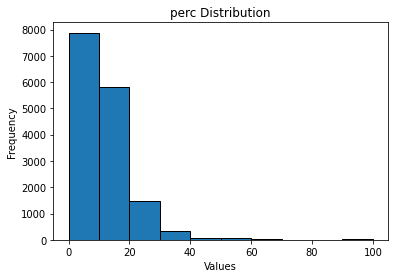

In [9]:
plt.hist(df_user["perc"], bins = 10, edgecolor = 'black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('perc Distribution')

# Mostra l'istogramma
plt.show()


In [10]:
freq, bins = np.histogram(df_user["perc"], bins=10) #15721
for i in range(0, 10):
    print(i, (freq[i]/len(df_user)*100), freq[i])

0 50.11131607404109 7878
1 36.95693658164239 5810
2 9.45232491571783 1486
3 2.2326823993384646 351
4 0.44526429616436614 70
5 0.4134597035811971 65
6 0.08905285923287323 14
7 0.02544367406653521 4
8 0.03816551109980281 6
9 0.23535398511545066 37


In [11]:
df_tox_comments = df_comments[df_comments["toxic"]==1]
df_tox_users = df_user[df_user["perc"] >= 10.0]

In [12]:
df_tox_comments.shape, df_tox_users.shape

((961251, 71), (7843, 184))

<h3>Label definition for the authors: <h3>

<ol>Binary (Toxic vs Non-toxic)</ol>
<ol>5 labels</ol>


In [13]:
def toxic_author(x):
    #comments of every user
    filtered_comments = df_tox_comments[df_tox_comments['author'] == x]
    
    #Average value for different toxicities
    tox_means = {
        "vulgarity": filtered_comments["obscene"].mean(),
        "harassment": filtered_comments["insult"].mean(),
        "violence": filtered_comments["threat"].mean(),
        "racism": filtered_comments["identity_attack"].mean()
    }
    
    #highest average 
    max_tox = max(tox_means, key=tox_means.get)
    
    return max_tox

In [14]:
df_tox_users["toxic_annotation"] = df_tox_users["author"].apply(toxic_author)

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_12859/1777482518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tox_users["toxic_annotation"] = df_tox_users["author"].apply(toxic_author)


In [15]:
df_tox_users["toxic_annotation"].value_counts()

toxic_annotation
vulgarity     7496
harassment     297
racism          34
violence        16
Name: count, dtype: int64

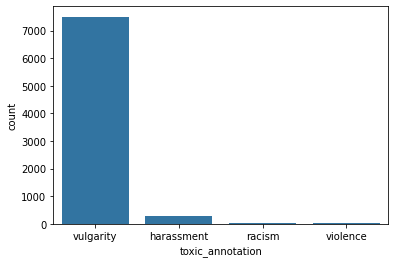

In [16]:
sns.countplot(x='toxic_annotation', data=df_tox_users) #perc>=10.0
plt.show()

In [17]:
df_merge = df_tox_users.iloc[:, [0,184]]

In [18]:
df_merge

,author,toxic_annotation
0,t2_100w5k,vulgarity
3,t2_1023m3xz,vulgarity
4,t2_102eed5v,harassment
7,t2_102q28,vulgarity
8,t2_102q4l,vulgarity
...,...,...
15713,t2_zxwos,vulgarity
15714,t2_zyj2s,vulgarity
15715,t2_zyj69,vulgarity
15716,t2_zykuy,vulgarity


In [19]:
df_users_merged = pd.merge(df_user, df_merge, on='author', how='left')

In [20]:
df_users_merged['toxic_annotation'].fillna("non-toxicity", inplace=True)

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_12859/1205731220.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_users_merged['toxic_annotation'].fillna("non-toxicity", inplace=True)


In [21]:
df_users_merged["toxic_annotation"].value_counts()

toxic_annotation
non-toxicity    7878
vulgarity       7496
harassment       297
racism            34
violence          16
Name: count, dtype: int64

In [24]:
df_users_merged = df_users_merged.fillna(0)

In [25]:
df_users_merged.to_csv("../file_csv/df_users_annotated_10.csv", index = False)